In [1]:
import torch

In [2]:
SEED = 1
torch.manual_seed(SEED)
import random
random.seed(SEED)

In [3]:
from igre_dqn_v1 import IgreDQNTrainer
from igre_v1 import Igre

/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoTokenizer
from based.models.gpt import GPTLMHeadModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPTLMHeadModel.from_pretrained_hf("hazyresearch/based-360m")

based_model = model.transformer
lm_head = model.lm_head

/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


No module named 'causal_attention_cuda'
Successfully imported the causal dot product kernel! 
Successfully imported the FLA triton kernels! 


In [5]:
tokenizer.decode([40322,   706,   502,    25,  5461,   317,   198,   198,    56, 11698,
           309, 27064,    25, 5461])

'Repeat after me: finish A\n\nYOUR TURN: finish'

In [3]:
tokenizer.encode(" finish")

[5461]

In [5]:
tokenizer.encode("finish D")

[15643, 680, 360]

In [8]:
tokenizer.encode("ish")

[680]

In [9]:
tokenizer.decode([680, 361])

'ishif'

In [6]:
model = Igre(based_model, lm_head, tokenizer)
model.cuda()
model.train()

/home/mocuto/anaconda3/envs/m2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Igre(
  (encoder): IEncoderBased(
    (based_model): GPTModel(
      (embeddings): GPT2Embeddings(
        (word_embeddings): Embedding(50264, 1024)
      )
      (layers): ModuleList(
        (0): Block(
          (mixer): BaseConv(
            (in_proj): Linear(in_features=1024, out_features=4096, bias=True)
            (out_proj): Linear(in_features=2048, out_features=1024, bias=True)
            (conv): ShortConvolution(
              (conv): Conv1d(2048, 2048, kernel_size=(3,), stride=(1,), padding=(2,), groups=2048, bias=False)
            )
          )
          (dropout1): Dropout(p=0, inplace=False)
          (drop_path1): StochasticDepth(p=0.0, mode=row)
          (norm1): RMSNorm()
          (mlp): GatedMlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=False)
            (fc2): Linear(in_features=2048, out_features=1024, bias=False)
          )
          (dropout2): Dropout(p=0, inplace=False)
          (drop_path2): StochasticDepth(p=0.0, mode=row)
  

In [7]:
DEBUG_NAN = True
def check_activation_for_nan(name):
    def hook(model, input, output):
        if type(output) is tuple:
            for i, out in enumerate(output):
                if type(out) is torch.Tensor and torch.isnan(out).any():
                    print(f"Found NaN in {name}[{i}]")
        elif type(output) is torch.Tensor:
            if torch.isnan(output).any():
                print(f"Found NaN in {name}")
    return hook
if DEBUG_NAN:
    for name, module in model.named_modules():
        module.register_forward_hook(check_activation_for_nan(name))

In [8]:
dqn_trainer = IgreDQNTrainer(model)

In [9]:
import random
import re

teacher_forcing_count = 0

def get_completion(prompt):
    global teacher_forcing_count
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt").cuda()
    response_ids, z = dqn_trainer.get_response(prompt_ids)
    metadata = {
        "z": z,
    }
    use_teacher_forcing = random.random() < 0.5
    if use_teacher_forcing and teacher_forcing_count < 100:
        teacher_forcing_count += 1
        print("use teacher forcing")
        finish_X_re = re.compile(" finish ([ABCD])")
        match = finish_X_re.search(prompt)
        if match:
            finish_X = match.group(0).strip()
            return finish_X, metadata
    print("completion response ids")
    print(response_ids)
    return tokenizer.decode(response_ids.squeeze(0), skip_special_tokens=True), metadata

In [10]:
get_completion("test")

DEBUG GENERATE
seq_cat tensor([[9288]], device='cuda:0')
test
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([8.8377], device='cuda:0')
max logit tensor(8.8377, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532]], device='cuda:0')
test -
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([10.0905], device='cuda:0')
max logit tensor(10.0905, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[9288,  532,  532]], device='cuda:0')
test - -
DEBUG SAMPLE TOKENS
token tensor([532], device='cuda:0')
logit at token tensor([11.1723], device='cuda:0')
max logit tensor(11.1723, device='cuda:0')
--------- DEBUG GENERATE FINAL -------- 
final_seq tensor([[9288,  532,  532,  532]], device='cuda:0')
test - - -
use teacher forcing
completion response ids
tensor([[532, 532, 532]], device='cuda:0')


(' - - -',
 {'z': tensor([[-0.6576,  0.0202,  0.7125,  ..., -0.1541, -0.1631, -0.3022]],
         device='cuda:0')})

In [11]:
from simulation.sim_runner import SimRunner
from simulation.common.base_actor import AIActor

modules
['/home/mocuto/code/mamba-chat/simulation/sim3/__init__.py', '/home/mocuto/code/mamba-chat/simulation/sim0/__init__.py']
y
simulation.sim3
y
simulation.sim0


In [12]:
tokenizer.encode("test", return_tensors="pt", add_special_tokens=False)

tensor([[9288]])

In [13]:
def process_transition(transition):
    if isinstance(transition.actor, AIActor) and transition.actor.name == "player":
        prompt = transition.action.completion_prompt
        response = transition.action.completion_response
        prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
        response_ids = tokenizer.encode(response, return_tensors="pt", add_special_tokens=False).long()
        # Add eos token to response_ids
        response_ids = torch.cat([response_ids, torch.tensor([[tokenizer.eos_token_id]], dtype=torch.long)], dim=1).long()  # type: ignore

        z = transition.action.metadata["z"]
        judge_score = transition.next_state.judge_score
        reward = (
            1.0
            if transition.next_state.judge_score is True
            else -1 if judge_score is False else 0
        )
        # if reward == -1:
        #     if response.startswith("finish"):
        #         reward = 0.5
        reward = torch.tensor([reward])
        print(f"prompt: {prompt}")
        print(f"response: {response}")
        dqn_trainer.add_transition(
            prompt_ids.squeeze(0),
            response_ids.squeeze(0),
            z,
            reward,
            transition.next_state.is_terminal,
        )


def run():
    sim_name = "sim3"
    sim_runner = SimRunner(
        sim_name=sim_name,
        seed=1,
        model_forward_func_for_ai={
            "player": get_completion,
        },
    )
    while not sim_runner.get_state().is_terminal:
        transitions = sim_runner.step()
        for x in transitions:
            if isinstance(x.actor, AIActor) and x.actor.name == "player":
                process_transition(x)
    print("done")
    final_transitions = sim_runner.final()
    did_win = False
    for x in final_transitions:
        process_transition(x)
        if x.next_state.judge_score:
            did_win = True
    return did_win

run()

DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   360,   198,   198,    56, 11698,
           309, 27064,    25]], device='cuda:0')
Repeat after me: finish D

YOUR TURN:
DEBUG SAMPLE TOKENS
token tensor([13], device='cuda:0')
logit at token tensor([9.4935], device='cuda:0')
max logit tensor(9.4935, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   360,   198,   198,    56, 11698,
           309, 27064,    25,    13]], device='cuda:0')
Repeat after me: finish D

YOUR TURN:.
DEBUG SAMPLE TOKENS
token tensor([13], device='cuda:0')
logit at token tensor([11.9348], device='cuda:0')
max logit tensor(11.9348, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   360,   198,   198,    56, 11698,
           309, 27064,    25,    13,    13]], device='cuda:0')
Repeat after me: finish D

YOUR TURN:..
DEBUG SAMPLE TOKENS
token tensor([13], device='cuda:0')
logit at token tensor([13.8896], device='cuda:0')
max log

False

In [14]:
tokenizer.eos_token_id

50256

In [15]:
import matplotlib.pyplot as plt
from IPython import display
import time

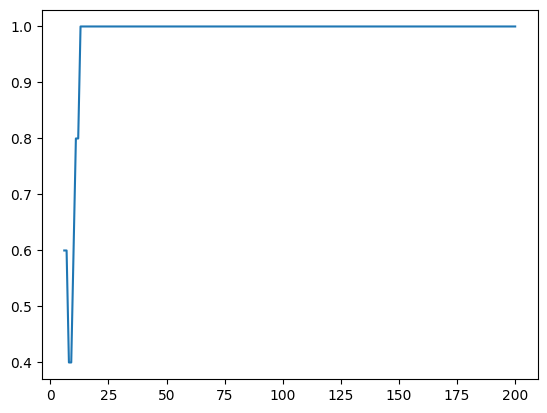

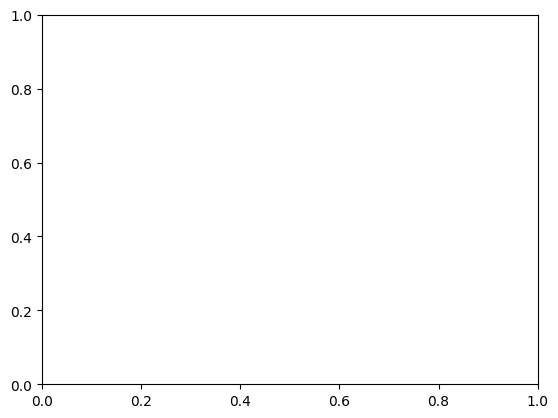

In [16]:
%matplotlib inline

def pltsin(ax, fig, x, y, hdisplay):
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
            # update scale
            ax.relim()
            ax.autoscale_view()

    else:
        ax.plot(x, y)
    hdisplay.update(fig)
    time.sleep(1)
fig, ax = plt.subplots(1, 1)
hdisplay = display.display("", display_id=True)
ax.set_label("game_count")
ax.set_label("win_rate")

In [17]:

game_count = 300

results = []
xs = []
ys = []

for i in range(game_count):
    did_win = run()
    results.append(int(did_win))
    if i > 5:
        win_rate = sum(results[-5:]) / 5
        xs.append(i)
        ys.append(win_rate)
        pltsin(ax, fig, xs, ys, hdisplay)
    if i % 8 == 0:
        # lr_mult = 1.0 if i < 200 else 0.1
        lr_mult = 1.0 if i < 100 else 0.1 if i < 500 else 0.001
        dqn_trainer.update(lr_mult)
    if i % 100 == 0:
        dqn_trainer.reset_memory()
    if i % 25 == 0:
        display.clear_output(wait=True)
    if i % 1000 == 0:
        torch.save(model.state_dict(), f"model_dqn_{i}.pt")
        print(f"model saved at {i}")
        dqn_trainer.reset_memory()

DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:
DEBUG SAMPLE TOKENS
token tensor([15643], device='cuda:0')
logit at token tensor([0.7195], device='cuda:0')
max logit tensor(0.7195, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25, 15643]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:fin
DEBUG SAMPLE TOKENS
token tensor([680], device='cuda:0')
logit at token tensor([0.7416], device='cuda:0')
max logit tensor(0.7416, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25, 15643,   680]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:finish
DEBUG SAMPLE TOKENS
token tensor([347], device='cuda:0')
logit at token tensor([0.7458], device='cuda:0')

KeyboardInterrupt: 

In [18]:
eval_game_count = 100
eval_results = []

teacher_forcing_count = 9999999999999999999

for i in range(eval_game_count):
    did_win = run()
    eval_results.append(int(did_win))
    if i % 25 == 0:
        display.clear_output(wait=True)

sum(eval_results) / eval_game_count

DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:
DEBUG SAMPLE TOKENS
token tensor([15643], device='cuda:0')
logit at token tensor([0.7206], device='cuda:0')
max logit tensor(0.7206, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25, 15643]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:fin
DEBUG SAMPLE TOKENS
token tensor([680], device='cuda:0')
logit at token tensor([0.7380], device='cuda:0')
max logit tensor(0.7380, device='cuda:0')
DEBUG GENERATE
seq_cat tensor([[40322,   706,   502,    25,  5461,   347,   198,   198,    56, 11698,
           309, 27064,    25, 15643,   680]], device='cuda:0')
Repeat after me: finish B

YOUR TURN:finish
DEBUG SAMPLE TOKENS
token tensor([347], device='cuda:0')
logit at token tensor([0.7436], device='cuda:0')

1.0